In [1]:
%load_ext autoreload
%autoreload 2
%cd /home/xux/Desktop/Enzyme_design/Savi_design/Savinase-engineering

/home/xux/Desktop/Enzyme_design/Savi_design/Savinase-engineering


In [2]:
import pandas as pd
from Levenshtein import distance as levenshtein_distance

# Load data

In [4]:
agent_data_path = 'data/round2/results/run1_all_step_aa_seqs.csv'

agent_data = pd.read_csv(agent_data_path)
print(len(agent_data)), print(list(agent_data.columns))
display(agent_data[['weight', 'raw_activity']].sample())

179982
['step', 'aa_seqs', 'weight', 'activity', 'raw_activity', 'agent_likelihood', 'prior_likelihood', 'augmented_likelihood']


,weight,raw_activity
34895,0.646655,1.524947


## Calculate edit distance and seq length

In [5]:
savinase = 'AQSVPWGISRVQAPAAHNRGLTGSGVKVAVLDTGISTHPDLNIRGGASFVPGEPSTQDGNGHGTHVAGTIAALNNSIGVLGVAPSAELYAVKVLGASGSGSVSSIAQGLEWAGNNGMHVANLSLGSPSPSATLEQAVNSATSRGVLVVAASGNSGAGSISYPARYANAMAVGATDQNNNRASFSQYGAGLDIVAPGVNVQSTYPGSTYASLNGTSMATPHVAGAAALVKQKNPSWSNVQIRNHLKNTATSLGSTNLYGSGLVNAEAATR'

def edit_distance2wildtype(variant_seq, wildtype=savinase):
    try:
        return levenshtein_distance(variant_seq, wildtype)
    except:
        raise Exception(f"variant_seq value error {variant_seq}")

In [6]:
agent_data['is_success'] = (agent_data.raw_activity >= 0)
agent_data['dist2wt'] = [edit_distance2wildtype(seq) for seq in agent_data['aa_seqs']]
agent_data['seq_len'] = agent_data['aa_seqs'].str.len()

opt_step = agent_data.sort_values(by=['step'])


# Plot step figure

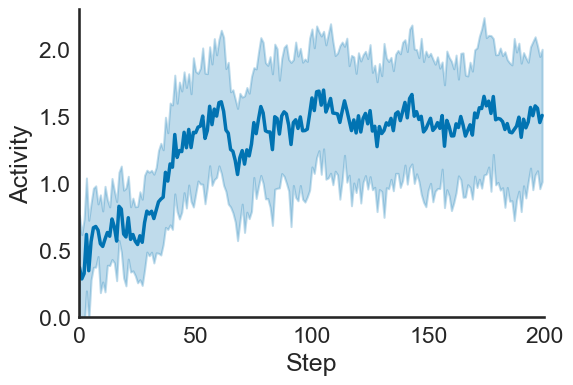

In [7]:
from utils import plot_style_utils

plot_style_utils.set_pub_plot_context(context="talk")

fig, ax = plot_style_utils.simple_ax()
plot_style_utils.prettify_ax(ax)

prop = 'raw_activity'
ylabel = 'Activity'
n_step = 200

df_plot = opt_step[opt_step.step < n_step][['step', prop]].groupby('step').mean()
df_plot_std = opt_step[opt_step.step < n_step][['step', prop]].groupby('step').std()

# Better color scheme: Professional blue with complementary fill
line_color = plot_style_utils.CAT_PALETTE[0]  # Use the first color from the palette

ax.plot(df_plot.index.values, df_plot[prop].values, 
        color=line_color, linewidth=2.5)
ax.fill_between(df_plot.index.values, 
                df_plot[prop].values - df_plot_std[prop].values, 
                df_plot[prop].values + df_plot_std[prop].values, 
                color=line_color,
                alpha=0.25)
ax.set_xlabel('Step')
ax.set_ylabel(ylabel)
ax.set_xlim(0, n_step)
ax.set_ylim(0, 2.3)
plot_style_utils.save_for_pub(fig, path='figures/round2/step_activity')


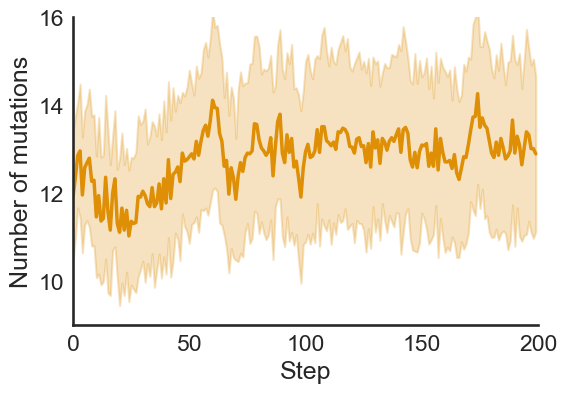

In [8]:
from utils import plot_style_utils

plot_style_utils.set_pub_plot_context(context="talk")

fig, ax = plot_style_utils.simple_ax()
plot_style_utils.prettify_ax(ax)

prop = 'dist2wt'
ylabel = 'Number of mutations'
n_step = 200

df_plot = opt_step[opt_step.step < n_step][['step', prop]].groupby('step').mean()
df_plot_std = opt_step[opt_step.step < n_step][['step', prop]].groupby('step').std()

# Consistent color theme with the first plot
line_color = plot_style_utils.CAT_PALETTE[1]

ax.plot(df_plot.index.values, df_plot[prop].values, 
        color=line_color, linewidth=2.5)

ax.fill_between(df_plot.index.values, 
                df_plot[prop].values - df_plot_std[prop].values, 
                df_plot[prop].values + df_plot_std[prop].values, 
                color=line_color,
                alpha=0.25)
ax.set_xlabel('Step')
ax.set_ylabel(ylabel)
ax.set_xlim(0, n_step)
ax.set_ylim(9, 16)
plot_style_utils.save_for_pub(fig, path='figures/round2/step_n_mutations')


# Filter success molecules

In [9]:
agent_data_success = agent_data[agent_data.is_success == True]
agent_data_success.to_csv(agent_data_path + '_success.csv', index=False)
print(f"Saved to path {agent_data_path + '_success.csv'}")

len(agent_data_success), agent_data_success.seq_len.min(),agent_data_success.seq_len.max()

Saved to path data/round2/results/run1_all_step_aa_seqs.csv_success.csv


(179839, 269, 269)

## Remove duplicates and save unique seqs

In [10]:
agent_data_success_sorted = agent_data_success.sort_values(by=['step'])
agent_data_success_uniq = agent_data_success_sorted.drop_duplicates('aa_seqs', keep='first')
agent_data_success_uniq.to_csv(agent_data_path+'_success.csv_uniq.csv', index=False)
print(f"file saved to {agent_data_path}_success.csv_uniq.csv")

len(agent_data_success_uniq), len(agent_data_success.aa_seqs.unique())

file saved to data/round2/results/run1_all_step_aa_seqs.csv_success.csv_uniq.csv


(174298, 174298)

## Show trend of novel sequences

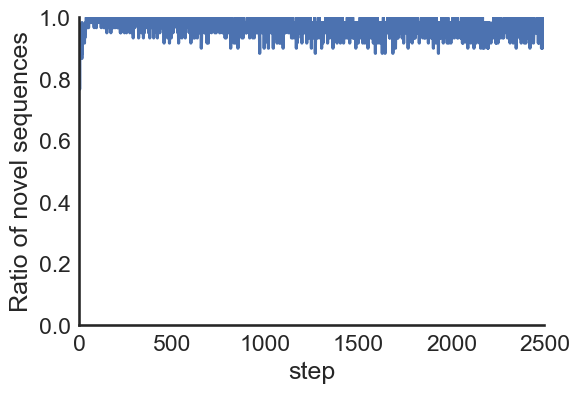

In [11]:
from utils import plot_style_utils

plot_style_utils.set_pub_plot_context(context="talk")

fig, ax = plot_style_utils.simple_ax()
plot_style_utils.prettify_ax(ax)

batch_size = 60

(agent_data_success_uniq[['step','aa_seqs']].groupby('step').count()/batch_size).plot(ax=ax)
ax.get_legend().remove()
ax.set_ylabel('Ratio of novel sequences')
ax.set_xlim(0, 2500)
ax.set_ylim(0, 1)

plot_style_utils.save_for_pub(fig, path='figures/round2/step_novel_seqs')